In [1]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D,Flatten,Dense,MaxPooling2D,Dropout
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import cv2
from sklearn.utils import shuffle
import tensorflow as tf
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pathlib

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("agungmrf/indonesian-sign-language-bisindo")

print("Path to dataset files:", path)

100%|██████████| 1.36G/1.36G [01:07<00:00, 21.6MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/agungmrf/indonesian-sign-language-bisindo/versions/1


In [3]:
path_train = '/root/.cache/kagglehub/datasets/agungmrf/indonesian-sign-language-bisindo/versions/1/bisindo/images/train'

In [4]:
train_datagen = ImageDataGenerator(
                rescale=1./255,
                horizontal_flip=True,
                shear_range = 0.2,
                zoom_range=0.15,
                width_shift_range=0.2,
                height_shift_range=0.2,
                fill_mode = 'nearest',
                validation_split=0.2)

validation_datagen = ImageDataGenerator(rescale = 1.0/255,
                                        validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
        path_train,
        target_size=(100,100),
        batch_size=32,
        class_mode='categorical',
        shuffle=True,
        subset='training')

validation_generator = validation_datagen.flow_from_directory(
        path_train,
        target_size=(100,100),
        batch_size=32,
        class_mode='categorical',
        shuffle=False,
        subset='validation')

Found 7342 images belonging to 26 classes.
Found 1827 images belonging to 26 classes.


In [5]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(100, 100, 3)),
    tf.keras.layers.MaxPooling2D(2, 2, padding='same'),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(2, 2, padding='same'),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(2, 2, padding='same'),
    tf.keras.layers.Dropout(0.4),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(26, activation='softmax')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [6]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 100, 100, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 50, 50, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 50, 50, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 50, 50, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 25, 25, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 25, 25, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 25, 25, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 13, 13, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 13, 13, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 21632)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      11,076,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 26)                  │           3,354 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,238,362 (42.87 MB)

 Trainable params: 11,238,362 (42.87 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

In [8]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [9]:
es=EarlyStopping(monitor='accuracy',verbose=1,patience=8,mode='auto')
mc=ModelCheckpoint(filepath='/content.keras',monitor='accuracy',verbose=1,save_best_only=True)
lr=ReduceLROnPlateau(monitor='accuracy',verbose=1,patience=5,min_lr=0.001)

In [10]:
history = model.fit(
    train_generator,
    epochs=200,
    validation_data=validation_generator,
    callbacks=[mc,es,lr]
)

Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


229/230 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - accuracy: 0.0352 - loss: 3.2802
Epoch 1: accuracy improved from -inf to 0.03746, saving model to /content.keras
230/230 ━━━━━━━━━━━━━━━━━━━━ 73s 274ms/step - accuracy: 0.0352 - loss: 3.2801 - val_accuracy: 0.0449 - val_loss: 3.2578 - learning_rate: 1.0000e-04
Epoch 2/200
229/230 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - accuracy: 0.0344 - loss: 3.2572
Epoch 2: accuracy did not improve from 0.03746
230/230 ━━━━━━━━━━━━━━━━━━━━ 53s 224ms/step - accuracy: 0.0345 - loss: 3.2572 - val_accuracy: 0.0416 - val_loss: 3.2562 - learning_rate: 1.0000e-04
Epoch 3/200
229/230 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - accuracy: 0.0435 - loss: 3.2553
Epoch 3: accuracy improved from 0.03746 to 0.04958, saving model to /content.keras
230/230 ━━━━━━━━━━━━━━━━━━━━ 82s 224ms/step - accuracy: 0.0435 - loss: 3.2553 - val_accuracy: 0.0865 - val_loss: 3.2253 - learning_rate: 1.0000e-04
Epoch 4/200
229/230 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.0708 - loss: 3.2036
Ep

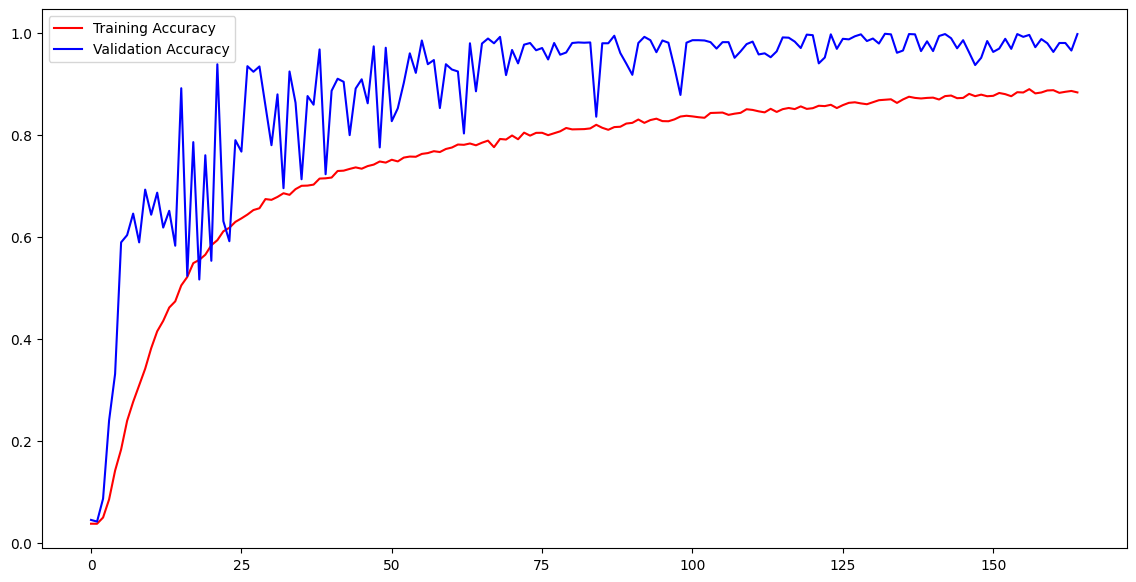

In [11]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))
fig = plt.figure(figsize=(14,7))
plt.plot(epochs,acc,'r',label="Training Accuracy")
plt.plot(epochs,val_acc,'b',label="Validation Accuracy")
plt.legend(loc='upper left')
plt.show()

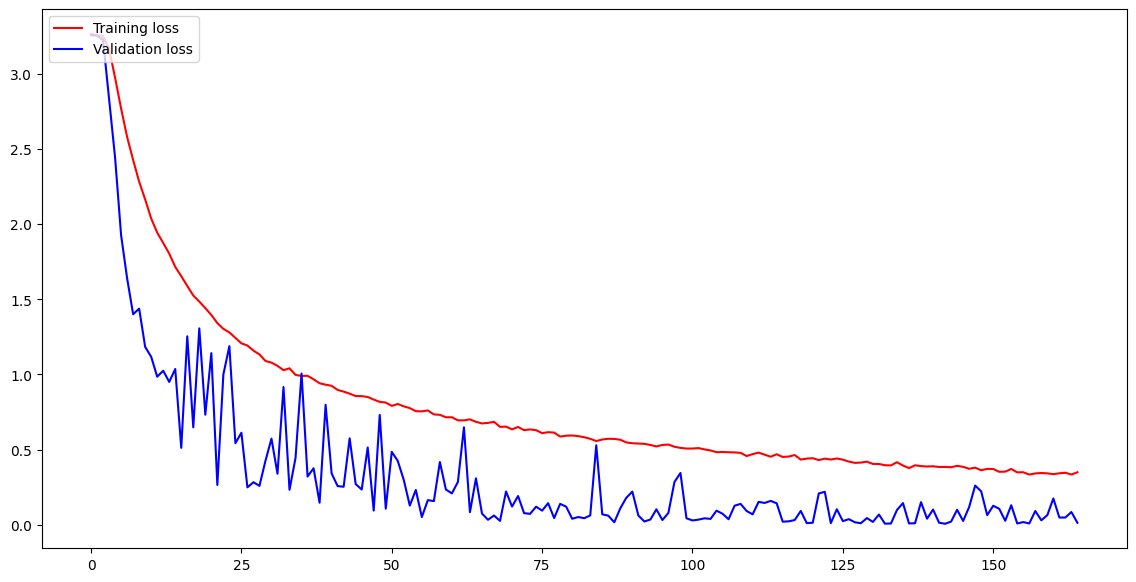

In [12]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))
fig = plt.figure(figsize=(14,7))
plt.plot(epochs,loss,'r',label="Training loss")
plt.plot(epochs,val_loss,'b',label="Validation loss")
plt.legend(loc='upper left')
plt.show()

In [13]:
# Menyimpan model (struktur + weights)
model.save('my_model.h5')

In [14]:
model.save('my_model.keras')

In [15]:
# Menyimpan hanya weights
model.save_weights('my_model.weights.h5')

In [16]:
alphabet_labels = [
    'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O',
    'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z'
]

def predict_image(image_upload, model):
    im = image_upload
    im_array = np.asarray(im)
    im_array = im_array / 255.0
    im_input = tf.reshape(im_array, shape=[1, 100, 100, 3])

    predict_proba = sorted(model.predict(im_input)[0])[2]
    predict_class = np.argmax(model.predict(im_input))

    print('\n')
    plt.imshow(im)
    plt.show()

    predict_label = alphabet_labels[predict_class]

    print("\nImage prediction result: ", predict_label)
    print("Probability: ", round(predict_proba * 100, 2), "%")
    print('\n')

Saving WIN_20241203_03_25_46_Pro.jpg to WIN_20241203_03_25_46_Pro.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step




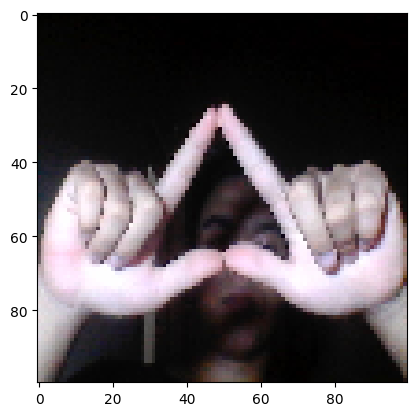


Image prediction result:  L
Probability:  0.0 %




In [21]:
from google.colab import files
from keras.preprocessing import image
uploaded = files.upload()

for fn in uploaded.keys():
    path = fn
    img = image.load_img(path, target_size=(100, 100))
    imgplot = plt.imshow(img)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)

    predict_image(img, model)

Saving WIN_20241203_03_26_32_Pro.jpg to WIN_20241203_03_26_32_Pro.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step




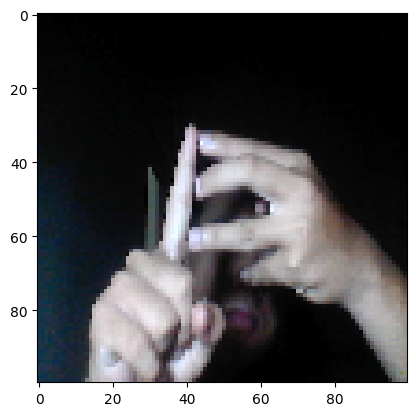


Image prediction result:  Z
Probability:  0.01 %




In [20]:
from google.colab import files
from keras.preprocessing import image
uploaded = files.upload()

for fn in uploaded.keys():
    path = fn
    img = image.load_img(path, target_size=(100, 100))
    imgplot = plt.imshow(img)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)

    predict_image(img, model)

In [ ]:
export_dir = 'saved_model/'
tf.saved_model.save(model, export_dir)

converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

tflite_model_file = pathlib.Path('vegs.tflite')
tflite_model_file.write_bytes(tflite_model)

In [1]:
from google.colab import files
import shutil
# Mendownload seluruh direktori di Google Colab
def download_directory(directory_path, output_filename):
    shutil.make_archive(output_filename, 'zip', directory_path)
    files.download(output_filename + '.zip')

In [2]:
download_directory('/content/saved_model', 'tflitemodel2')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>